In [1]:
from sklearn.datasets import fetch_20newsgroups

# 20개의 토픽 중 선택하고자 하는 토픽을 리스트로 생성
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# 학습 데이터셋 불러오기
# 메일 내용에서 hint가 되는 부분 삭제 - 순수하게 내용만으로 분류
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)

# 평가 데이터셋을 가져옴
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

X_train = newsgroups_train.data # 학습 데이터셋 문서
y_train = newsgroups_train.target # 학습 데이터셋 라벨

X_test = newsgroups_test.data # 평가 데이터셋 문서
y_test = newsgroups_test.target # 평가 데이터셋 라벨

RegTok = RegexpTokenizer("[\w']{3,}") # 정규 표현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) # 영어 불용어를 가져옴

def tokenizer(text):
  tokens = RegTok.tokenize(text.lower())
  # stopwords 제외
  words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
  # porter stemmer 적용
  features = (list(map(lambda token: PorterStemmer().stem(token), words)))
  return features

tfidf = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train) # train set을 변환
X_test_tfidf = tfidf.transform(X_test) # test set을 변환

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from sklearn.linear_model import LogisticRegression
LR_clf = LogisticRegression() # 분류기 선언
LR_clf.fit(X_train_tfidf, y_train) # train data를 이용해 분류기를 학습
print('#Train set score: {:.3f}'.format(LR_clf.score(X_train_tfidf, y_train)))
print('#Test set score: {:.3f}'.format(LR_clf.score(X_test_tfidf, y_test)))

#Train set score: 0.962
#Test set score: 0.761


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2000, random_state=7)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

print('Original tfidf matrix shape:', X_train_tfidf.shape)
print('PCA tfidf matrix shape: ', X_train_pca.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        pca.explained_variance_ratio_.sum()
    )
)

Original tfidf matrix shape: (2034, 20085)
PCA tfidf matrix shape:  (2034, 2000)
Sum of explained variance ratio: 1.000


In [5]:
LR_clf.fit(X_train_pca, y_train)
print('#Train set score: {:.3f}'.format(LR_clf.score(X_train_pca, y_train)))
print('#Test set score: {:.3f}'.format(LR_clf.score(X_test_pca, y_test)))

#Train set score: 0.962
#Test set score: 0.761


In [6]:
lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=1)
lasso_clf.fit(X_train_tfidf, y_train)

print('#Train set score: {:.3f}'.format(lasso_clf.score(X_train_tfidf, y_train)))
print('#Test set score: {:.3f}'.format(lasso_clf.score(X_test_tfidf, y_test)))

import numpy as np
# 계수 중에서 0아 아닌 것들의 개수를 출력
print(
    "#Used features count: {}".format(np.sum(lasso_clf.coef_ !=0)),
    "out of",
    X_train_tfidf.shape[1],
)

#Train set score: 0.790
#Test set score: 0.718
#Used features count: 321 out of 20085


In [7]:
pca = PCA(n_components=321, random_state=7)

X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())
print('PCA Converted X shape:', X_train_pca.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        pca.explained_variance_ratio_.sum()
    )
)

LR_clf.fit(X_train_pca, y_train)
print('#Train set score: {:.3f}'.format(LR_clf.score(X_train_pca, y_train)))
print('#Test set score: {:.3f}'.format(LR_clf.score(X_test_pca, y_test)))

PCA Converted X shape: (2034, 321)
Sum of explained variance ratio: 0.437
#Train set score: 0.875
#Test set score: 0.751


In [8]:
pca = PCA(n_components=100, random_state=7)

X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())
print('PCA Converted X shape:', X_train_pca.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        pca.explained_variance_ratio_.sum()
    )
)

LR_clf.fit(X_train_pca, y_train)
print('#Train set score: {:.3f}'.format(LR_clf.score(X_train_pca, y_train)))
print('#Test set score: {:.3f}'.format(LR_clf.score(X_test_pca, y_test)))

PCA Converted X shape: (2034, 100)
Sum of explained variance ratio: 0.211
#Train set score: 0.807
#Test set score: 0.738


In [11]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2000, random_state=7) # 압축할 component의 수 지정
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)
print('LSA Converted X shape:', X_train_lsa.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        svd.explained_variance_ratio_.sum()
    )
)

LR_clf.fit(X_train_lsa, y_train)
print('#Train set score: {:.3f}'.format(LR_clf.score(X_train_lsa, y_train)))
print('#Test set score: {:.3f}'.format(LR_clf.score(X_test_lsa, y_test)))

LSA Converted X shape: (2034, 2000)
Sum of explained variance ratio: 1.000
#Train set score: 0.962
#Test set score: 0.761


In [13]:
svd = TruncatedSVD(n_components=100, random_state=1) # 압축할 component의 수 100으로 지정
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)
print('LSA Converted X shape:', X_train_lsa.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        svd.explained_variance_ratio_.sum()
    )
)

LR_clf.fit(X_train_lsa, y_train)
print('#Train set score: {:.3f}'.format(LR_clf.score(X_train_lsa, y_train)))
print('#Test set score: {:.3f}'.format(LR_clf.score(X_test_lsa, y_test)))

LSA Converted X shape: (2034, 100)
Sum of explained variance ratio: 0.209
#Train set score: 0.810
#Test set score: 0.745


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

print('# 사용된 전체 카테고리:', newsgroups_train.target_names)
print('# 첫 문서의 카테고리:', y_train[0])

# 변환된 count vector와 기존 값들과의 similarity 계산
sim_result = cosine_similarity([X_train_lsa[0]], X_train_lsa)

print('#Top 20 유사도(lsa):\n', sorted(sim_result[0].round(2), reverse=True)[:20])
sim_index = (-sim_result[0]).argsort()[:20]
print('#Top 20 유사 뉴스의 인덱스(lsa):\n', sim_index)
sim_labels = [y_train[i] for i in sim_index]
print('#Top 20 유사 뉴스의 카테고리(lsa):\n', sim_labels)

# 사용된 전체 카테고리: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
# 첫 문서의 카테고리: 1
#Top 20 유사도(lsa):
 [1.0, 0.74, 0.74, 0.72, 0.7, 0.7, 0.69, 0.67, 0.66, 0.65, 0.65, 0.65, 0.63, 0.62, 0.62, 0.62, 0.57, 0.57, 0.55, 0.54]
#Top 20 유사 뉴스의 인덱스(lsa):
 [   0 1957 1674  501 1995 1490  790 1902 1575 1209 1728  892 1892  998
 1038 1826 1290 1089  867  151]
#Top 20 유사 뉴스의 카테고리(lsa):
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:
sim_result = cosine_similarity(X_train_tfidf[0], X_train_tfidf)

print("#Top 20 유사도(tfidf):\n", sorted(sim_result[0].round(2), reverse=True)[:20])
sim_index = (-sim_result[0]).argsort()[:20]
print("#Top 20 유사 뉴슈의 인덱스(tfidf):\n", sim_index)
sim_labels = [y_train[i] for i in sim_index]
print("#Top 20 유사 뉴스의 카테고리(tfidf):\n", sim_labels)

#Top 20 유사도(tfidf):
 [1.0, 0.3, 0.22, 0.21, 0.19, 0.19, 0.19, 0.17, 0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.14]
#Top 20 유사 뉴슈의 인덱스(tfidf):
 [   0 1575 1892 1490  501 1290 1013  998 1636 1705 1995 1957 1664  651
 1038  429 1089 1209 1728 1803]
#Top 20 유사 뉴스의 카테고리(tfidf):
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
svd = TruncatedSVD(n_components=10, random_state=1) # 압축할 component의 수 지정
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print('LSA Converted X shape', X_train_lsa.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        svd.explained_variance_ratio_.sum()
    )
)

terms = tfidf.get_feature_names_out()
def get_topics(model, feature_names, n=10):
    for idx, topic in enumerate(model.components_):
      print("Topic %d:" % (idx+1),
            [feature_names[i] for i in topic.argsort()[:-n-1:-1]])

get_topics(svd, terms)

LSA Converted X shape (2034, 10)
Sum of explained variance ratio: 0.045
Topic 1: ['would', 'one', 'god', 'think', 'use', 'peopl', 'know', 'like', 'say', 'space']
Topic 2: ['file', 'imag', 'thank', 'program', 'graphic', 'space', 'format', 'use', 'color', 'ftp']
Topic 3: ['space', 'orbit', 'nasa', 'launch', 'shuttl', 'satellit', 'year', 'moon', 'lunar', 'cost']
Topic 4: ['moral', 'object', 'system', 'valu', 'goal', 'think', 'anim', 'absolut', 'natur', 'defin']
Topic 5: ['ico', 'bobb', 'tek', 'beauchain', 'bronx', 'manhattan', 'sank', 'queen', 'vice', 'blew']
Topic 6: ['god', 'file', 'imag', 'object', 'moral', 'exist', 'space', 'format', 'system', 'color']
Topic 7: ['file', 'islam', 'imag', 'cview', 'use', 'format', 'color', 'muslim', 'religion', 'peopl']
Topic 8: ['post', 'file', 'space', 'islam', 'read', 'cview', 'format', 'articl', 'group', 'moral']
Topic 9: ['christian', 'graphic', 'imag', 'jesu', 'book', 'data', 'group', 'softwar', 'law', 'code']
Topic 10: ['exist', 'atheism', 'athei

In [18]:
tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.5)
X_train_tfidf = tfidf.fit_transform(X_train) # train set을 변환

svd = TruncatedSVD(n_components=100, random_state=1) # 압축할 component의 수 지정
X_train_lsa = svd.fit_transform(X_train_tfidf)

print("#components_의 shape:", svd.components_.shape)
print("#singular_values_의 shape:", svd.singular_values_.shape)
t_words = np.diag(svd.singular_values_).dot(svd.components_).T
print("#변환된 단어-잠재의미 행렬의 shape:", t_words.shape)

# t_words에서 space에 해당하는 벡터에 가져옴
source = t_words[np.where(tfidf.get_feature_names_out() == 'space')[0][0]]
# 변환된 count vector와 기존 값들과의 similarity 계산
sim_result = cosine_similarity([source], t_words)

print("#Top 20 유사도(tfidf):", sorted(sim_result[0].round(2), reverse=True)[:20])
sim_index = (-sim_result[0]).argsort()[:20]
print("#Top 20 유사 뉴스의 인덱스(tfidf):", sim_index)
sim_labels = [tfidf.get_feature_names_out()[i] for i in sim_index]
print("#Top 20 유사 뉴스의 카테고리(tfidf):", sim_labels)

#components_의 shape: (100, 1000)
#singular_values_의 shape: (100,)
#변환된 단어-잠재의미 행렬의 shape: (1000, 100)
#Top 20 유사도(tfidf): [1.0, 0.73, 0.72, 0.69, 0.66, 0.58, 0.56, 0.56, 0.54, 0.54, 0.52, 0.52, 0.52, 0.51, 0.51, 0.5, 0.5, 0.49, 0.48, 0.47]
#Top 20 유사 뉴스의 인덱스(tfidf): [812 314 754 829 594 679 720 650 785 565 101 435 606 545 854 746 669 856
 611 564]
#Top 20 유사 뉴스의 카테고리(tfidf): ['space', 'exploration', 'sci', 'station', 'office', 'propulsion', 'reports', 'planetary', 'shuttle', 'national', 'astro', 'international', 'operations', 'missions', 'technical', 'satellites', 'probes', 'telescope', 'orbiter', 'nasa']


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 코드
mpl.rcParams['axes.unicode_minus'] = False

TSNE dimension: (2034, 2)


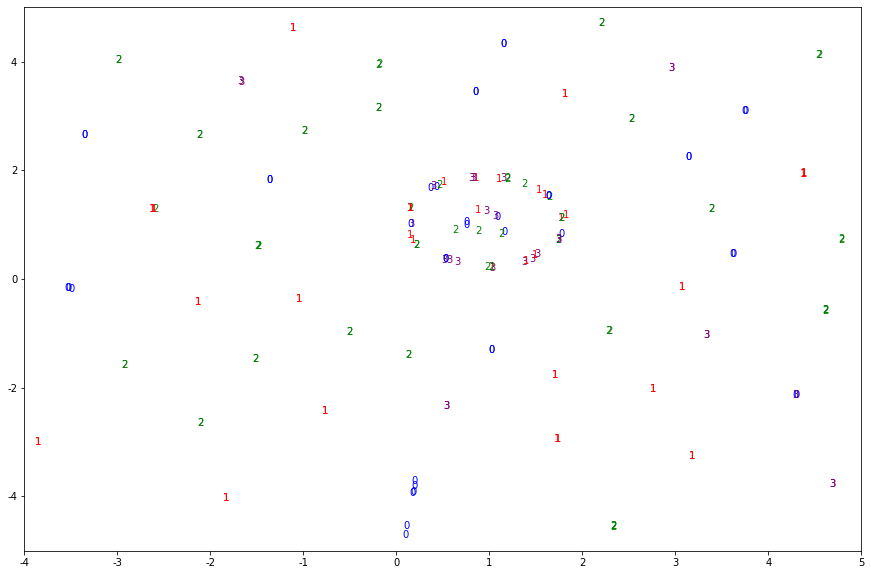

In [21]:
from sklearn.manifold import TSNE

tfidf = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = tfidf.fit_transform(X_train) # train set을 변환
X_test_tfidf = tfidf.transform(X_test) # test set을 변환

tsne = TSNE(n_components=2, random_state=7)
tsne_tfidf = tsne.fit_transform(X_train_tfidf)
print('TSNE dimension:', tsne_tfidf.shape)

def tsne_graph(tsne_2, label, lim=None):
    colors = {0:'blue', 1:'red', 2:'green', 3:'purple'}
    x = tsne_2[:,0]
    y = tsne_2[:,1] 
    plt.figure(figsize=(15,10))
    if lim == None:
        lim = [min(x), max(x), min(y), max(y)]
    plt.xlim(lim[0], lim[1])
    plt.ylim(lim[2], lim[3])
    for i in range(len(x)):
        #각 값에 대해 y값 즉 label에 따라 색을 바꿔가며 text로 그래프에 출력
        if (lim[0] < x[i] < lim[1]) and (lim[2] < y[i] < lim[3]):
            plt.text(x[i], y[i], label[i], color = colors[label[i]])
    plt.show()
    
tsne_graph(tsne_tfidf, y_train, (-4, 5, -5, 5))

LSA Converted X shape: (2034, 100)
Sum of explained variance ratio: 0.209


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE dimension: (2034, 2)
#Selected categories: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


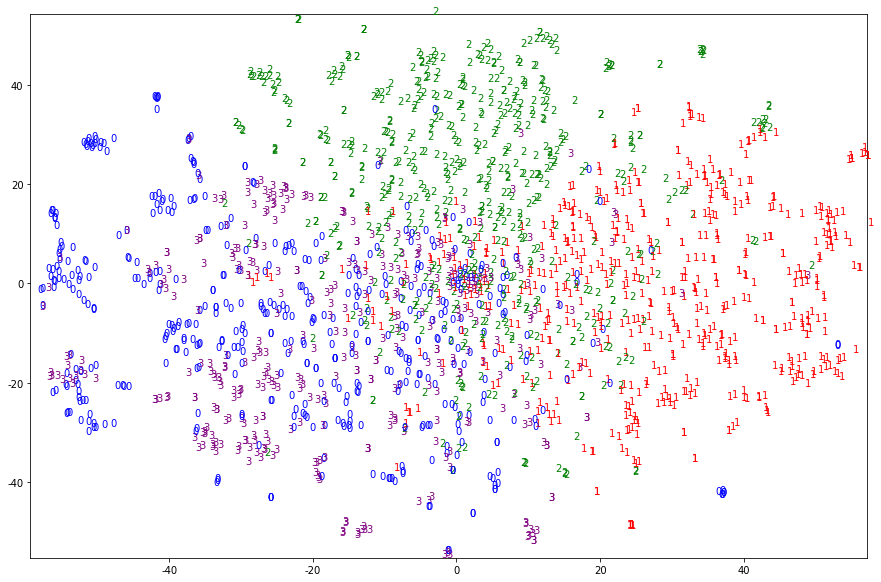

In [24]:
svd = TruncatedSVD(n_components=100, random_state=1) # 압축할 components의 수 지정
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)

print('LSA Converted X shape:', X_train_lsa.shape)
print(
    "Sum of explained variance ratio: {:.3f}".format(
        svd.explained_variance_ratio_.sum()
    )
)

tsne_lsa = tsne.fit_transform(X_train_lsa)
print('TSNE dimension:', tsne_lsa.shape)
print('#Selected categories:', newsgroups_train.target_names)

tsne_graph(tsne_lsa, y_train)